<a href="https://colab.research.google.com/github/Raulespz/cross_validation/blob/main/Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CROSS VALIDATION
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline


In [ ]:
# Note we are loading a slightly different ('cleaned') pickle file
boston = pickle.load(open('/content/boston_housing_clean (3).pickle', "rb"))

In [ ]:
boston.keys()

dict_keys(['dataframe', 'description'])

In [ ]:
boston_data = boston['dataframe']
boston_description = boston['description']

In [ ]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
#First from this data separate from x and y variables:
x = boston_data.drop('MEDV', axis=1) # drop is going to remove the outcome variable that is MEDV
y = boston_data.MEDV

In [ ]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [ ]:
for train_index, test_index in kf.split(x):
  print("Train index:", train_index[:10], len(train_index))
  print("Train index:", test_index[:10], len(test_index))
  print('')

Train index: [ 1  3  4  5  7  8 10 11 12 13] 337
Train index: [ 0  2  6  9 15 17 19 23 25 26] 169

Train index: [ 0  2  6  9 10 11 12 13 15 17] 337
Train index: [ 1  3  4  5  7  8 14 16 22 27] 169

Train index: [0 1 2 3 4 5 6 7 8 9] 338
Train index: [10 11 12 13 18 20 21 24 28 31] 168



In [ ]:
#from sklearn.metrics import r2_score, mean_squareed_error

scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(x):
  x_train, x_test, y_train, y_test = (x.iloc[train_index, :],
                                      x.iloc[test_index, :],
                                      y[train_index],
                                      y[test_index])

  lr.fit(x_train, y_train)

  y_pred = lr.predict(x_test)

  score = r2_score(y_test.values, y_pred)

  scores.append(score)

scores



[0.6719348798472742, 0.7485020059212382, 0.6976807323597771]

In [ ]:
# Now with a standardization in results:

scores = []

lr = LinearRegression()
s = StandardScaler()

for train_index, test_index in kf.split(x):
  x_train, x_test, y_train, y_test = (x.iloc[train_index, :],
                                      x.iloc[test_index, :],
                                      y[train_index],
                                      y[test_index])

  x_train_s = s.fit_transform(x_train)

  lr.fit(x_train_s, y_train)

  x_test_s = s.transform(x_test)

  y_pred = lr.predict(x_test_s)

  score = r2_score(y_test.values, y_pred)

  scores.append(score)

scores

[0.6719348798472715, 0.7485020059212382, 0.6976807323597745]

In [ ]:
#Hyperparameter tuning


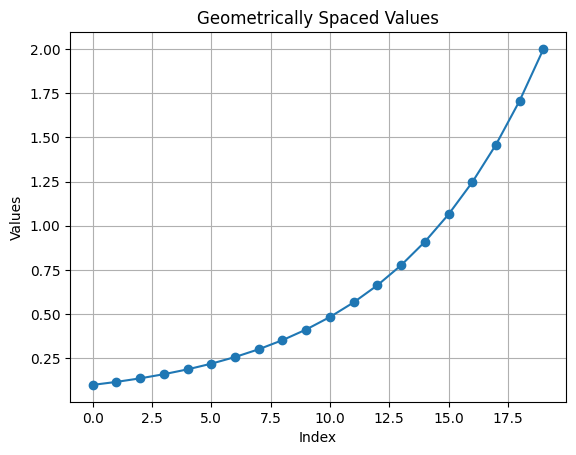

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.geomspace(0.1, 2, 20)

plt.plot(alphas, marker='o')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Geometrically Spaced Values')
plt.grid(True)
plt.show()

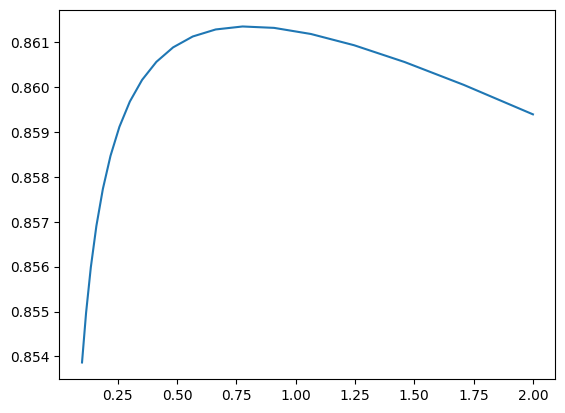

In [ ]:
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(0.1, 2, 20)
scores=[]

for alpha in alphas:
  ridge = Ridge(alpha=alpha, max_iter=100000)

  estimator = Pipeline([
      ("polynomial_features", pf),
      ("scaler", s),
      ("ridge_regression", ridge)])
  predictions = cross_val_predict(estimator, x, y, cv = kf)
  score = r2_score(y, predictions)
  scores.append(score)

plt.plot(alphas, scores)

In [ ]:
#Once we have found the hyperparameter (alpha-1e-2=0.01)
#Make the model and train in on ALL the data
#Then release it into the wild...
best_estimator = Pipeline([
    ("make_higher_degree", PolynomialFeatures(degree=2,include_bias=False)),
    ("scaler", s),
    ("lasso_regression", Lasso(alpha=0.01))])
best_estimator.fit(x, y)
best_estimator.score(x, y)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.387e+02, tolerance: 4.272e+00
  model = cd_fast.enet_coordinate_descent(


0.9047578542960124

In [ ]:
df_importances = pd.DataFrame(zip(x.columns,
                                  best_estimator.named_steps["lasso_regression"].coef_
                                 ),
                              columns=['Feature', 'Importance'])

#df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names(input_features=x.columns),
#                                  best_estimator.named_steps["lasso_regression"].coef_,
#                                  ))

In [ ]:
df_importances

,Feature,Importance
0,CRIM,-0.000000
1,ZN,-3.829855
2,INDUS,3.480146
3,CHAS,4.057486
4,NOX,0.345174
5,RM,2.084689
6,AGE,1.609912
7,DIS,-1.752046
8,RAD,0.000000
9,TAX,0.000000


In [ ]:
#df_importances.sort_values(by=1)

dfimportance = df_importances.sort_values(by='Importance', inplace=True)

dfimportance

In [ ]:
# Grid Search CV, or GridSearchCV, is a technique used for hyperparameter tuning in machine learning.
    # It is a process of systematically searching and evaluating a specified
    # set of hyperparameter combinations to find the best performing model.

from sklearn.model_selection import GridSearchCV

#Same estimator as before

estimator = Pipeline([
      ("polynomial_features", PolynomialFeatures()),
      ("scaler", StandardScaler()),
      ("ridge_regression", Ridge())])
params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)



In [ ]:
grid.fit(x, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [ ]:
grid.best_score_, grid.best_params_

(0.8546333782070428,
 {'polynomial_features__degree': 2, 'ridge_regression__alpha': 4.0})

In [ ]:
y_predict = grid.predict(x)

In [ ]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict)

0.8964707714558113

In [ ]:
grid.cv_results_

{'mean_fit_time': array([0.01283797, 0.00806522, 0.00734361, 0.00704002, 0.00712395,
        0.00692161, 0.00685692, 0.00898846, 0.00726366, 0.00730252,
        0.00709391, 0.00928235, 0.00996312, 0.00774527, 0.00753927,
        0.00713348, 0.00703907, 0.00691923, 0.01889126, 0.00696524,
        0.00678444, 0.00741553, 0.00987697, 0.00743063, 0.00690659,
        0.02250775, 0.02094754, 0.00841864, 0.00781043, 0.00774868,
        0.02920532, 0.03949507, 0.03256822, 0.0384268 , 0.04612676,
        0.05445838, 0.04703403, 0.03883966, 0.03437074, 0.01934139,
        0.01842642, 0.02002851, 0.01961692, 0.01905171, 0.01959276,
        0.02010544, 0.02658375, 0.01883213, 0.02004512, 0.0217758 ,
        0.02138225, 0.02222919, 0.02076435, 0.02122537, 0.02179821,
        0.01965149, 0.00781997, 0.00805314, 0.00863417, 0.01454568,
        0.03074884, 0.03857565, 0.04703188, 0.03902332, 0.03985047,
        0.0414803 , 0.01758838, 0.01742021, 0.02497506, 0.03703292,
        0.03838166, 0.03562021,

In [ ]:
# Notice that grid is a fit object!
# We can use grid.predict(x_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00,  2.47147038e-01, -1.18377806e+00,  1.11700133e+00,
        1.02268931e+00,  1.11573592e+00,  2.63515343e+00,  1.60400844e+00,
       -2.44378403e+00,  2.67549673e+00,  1.18120641e+00,  3.00931414e-01,
        7.17164316e-01,  5.46697603e-01,  1.16368605e+00,  2.78583120e-01,
        4.15770986e-01,  2.45396270e+00, -1.07012228e+00, -8.15812777e-01,
       -2.95036466e-01, -8.26480829e-01, -4.23552596e-01, -4.33022591e-02,
        8.34930099e-02, -4.92838202e-01,  5.12447325e-01,  5.88355149e-01,
       -3.50662224e-01, -1.39184102e-01, -2.99737738e-01,  1.02696466e+00,
        1.47705864e-02, -6.87593891e-01, -3.12176710e-01,  1.26476807e+00,
        1.01258007e+00, -5.51925730e-01, -8.62269698e-01,  8.78832853e-01,
        6.75975245e-02,  5.91362874e-01, -1.45086000e+00,  1.09286634e+00,
       -7.69112663e-01,  1.16978387e+00,  1.29460196e+00, -7.36888615e-01,
        7.29205860e-01, -2.44086792e+00,  1.02268931e+00, -2.26162754e+00,
       -2.56091292e+00,  

In [ ]:
##SUMMARY:

Summary/Review
Cross Validation

The three most common cross validation approaches are:

k-fold cross validation

leave one out cross validation

stratified cross validation


Cross validation method involves dividing the dataset into 3 parts:

training set - is a portion of the data used for training the model

validation set - is a portion of the data used to optimize the hyper-parameters of the model

test set - is a portion of the data used to evaluate the model


Cross Validation Syntax

`Scikit Learn` library contains many methods that can perform the splitting of the data into training, testing and validation sets. The most popular methods that we covered in this module are:

*   train_test_split - creates a single split into train and test sets

*   K-fold - creates number of k-fold splits, allowing cross validation

*   cross_val_score - evaluates model's score through cross validation

*   cross_val_predict – produces the out-of-bag prediction for each row

*   GridSearchCV – scans over parameters to select the best hyperparameter set with the best

     out-of-sample score